In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

#import statsmodels.api as sm
import statsmodels.tsa.api as smt
#import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mkt_sales_data = pd.read_csv('sales-and-marketing.csv')


In [3]:
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


In [4]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.434334
p-value                         0.997265
#lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [5]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

In [6]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data_diff['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.015650e+00
p-value                        6.743731e-10
#lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [7]:
mkt_sales_data['Mkt_Exp_Lag_1'] = mkt_sales_data['Marketing Expense'].shift(1)
mkt_sales_data['Mkt_Exp_Lag_2'] = mkt_sales_data['Marketing Expense'].shift(2)
mkt_sales_data['Mkt_Exp_Lag_3'] = mkt_sales_data['Marketing Expense'].shift(3)
mkt_sales_data['Mkt_Exp_Lag_4'] = mkt_sales_data['Marketing Expense'].shift(4)

In [8]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, temp_results.aic))
                
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
                
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [9]:
mkt_sales_data.dropna(inplace=True)
mkt_sales_data.head()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-05-01,596,744.15,565.16,437.09,501.80,486.64
2011-06-01,591,548.74,744.15,565.16,437.09,501.80
2011-07-01,651,650.21,548.74,744.15,565.16,437.09
2011-08-01,654,777.51,650.21,548.74,744.15,565.16
2011-09-01,509,547.11,777.51,650.21,548.74,744.15


In [11]:
import statsmodels.api as sm
sm.tsa.statespace.SARIMAX

statsmodels.tsa.statespace.sarimax.SARIMAX

In [12]:
timeseries = mkt_sales_data["Tractor-Sales"]
regressors = mkt_sales_data[["Marketing Expense", "Mkt_Exp_Lag_1", "Mkt_Exp_Lag_2"]]
best_results = auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 2), q=range(0, 2),
                         P=range(0, 2), D=range(0, 1), Q=range(0, 2))

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:510.8225704985192
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1279.5171729685708
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:310.03587577875646
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1018.1486820825298
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:486.8111334845112
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2094.2328682259167
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:306.1385210676917
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2151.1561012456777
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:488.13235101891337
SARIMAX(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1072.6883279335113
SARIMAX(0, 1, 0)x(1, 0, 0, 12)12 - AIC:298.7640151982344
SARIMAX(0, 1, 0)x(1, 0, 1, 12)12 - AIC:291.5787966022076
SARIMAX(0, 1, 1)x(0, 0, 0, 12)12 - AIC:474.62197275481645
SARIMAX(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1398.1311894489218
SARIMAX(0, 1, 1)x(1, 0, 0, 12)12 - AIC:289.71267963159767
SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 - AIC:273.4843871799599
SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 - AIC:499.88478513721986
SARIMAX(1, 0, 0)x(0,

In [13]:
best_model = sm.tsa.statespace.SARIMAX(timeseries,
                                      exog = regressors,
                                      order=(1, 1, 0),
                                      seasonal_order=(1, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [14]:
print(best_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -135.148
Date:                            Thu, 10 Mar 2022   AIC                            282.295
Time:                                    15:53:52   BIC                            290.702
Sample:                                05-01-2011   HQIC                           284.985
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0016      0.041      0.040      0.968      -0.080       0.083
Mkt_Exp_Lag_1 

In [15]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

pred_dynamic.predicted_mean

2014-01-01    532.391296
2014-02-01    528.597679
2014-03-01    641.437130
2014-04-01    659.654420
2014-05-01    782.822467
2014-06-01    768.296017
2014-07-01    858.327967
2014-08-01    875.595195
2014-09-01    649.548053
2014-10-01    564.844682
2014-11-01    537.329170
2014-12-01    625.703257
Freq: MS, Name: predicted_mean, dtype: float64

In [16]:
forecast = pred_dynamic.predicted_mean
actual = mkt_sales_data['2014-01-01':]['Tractor-Sales']

In [17]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0327


In [18]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 678.4472
The ROOT Mean Squared Error of our forecasts is 26.04701902329708


In [19]:
Future_mkt_spend = {
    '2015-01-01' : [600, 559.75, 527.60],
    '2015-02-01' : [550, 600, 559.75],
    '2015-03-01' : [700, 550, 600],
    '2015-04-01' : [590, 700, 550],
    '2015-05-01' : [480, 590, 700],
    '2015-06-01' : [520, 480, 590],
    '2015-07-01' : [800, 520, 480],
    '2015-08-01' : [675, 800, 520],
    '2015-09-01' : [820, 675, 800],
    '2015-10-01' : [710, 820, 675],
    '2015-11-01' : [550, 710, 820],
    '2015-12-01' : [590, 550, 710]
}

In [20]:
Future_mkt_spend = pd.DataFrame(Future_mkt_spend).T

In [21]:
Future_mkt_spend.columns = ['Marketing Expense', 'Mkt_Exp_Lag_1', 'Mkt_Exp_Lag_2']

In [22]:
#Forecast for next 12 Months
best_results.forecast(steps=12, exog=Future_mkt_spend)

2015-01-01    562.280028
2015-02-01    559.482882
2015-03-01    628.947677
2015-04-01    775.317137
2015-05-01    863.217371
2015-06-01    824.207622
2015-07-01    978.246627
2015-08-01    956.313071
2015-09-01    705.383960
2015-10-01    635.024933
2015-11-01    553.749841
2015-12-01    649.498407
Freq: MS, Name: predicted_mean, dtype: float64

In [23]:
n_steps = 12
pred_uc_99 = best_results.get_forecast(steps=12, alpha=0.01, exog=Future_mkt_spend) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=12, alpha=0.05, exog=Future_mkt_spend) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [24]:
n_steps = 12
idx = pd.date_range(mkt_sales_data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,562.280028,519.378935,605.181120,519.378935,605.181120
2015-01-01,559.482882,512.541393,606.424370,512.541393,606.424370
2015-02-01,628.947677,571.961449,685.933906,571.961449,685.933906
2015-03-01,775.317137,713.112295,837.521980,713.112295,837.521980
2015-04-01,863.217371,794.569086,931.865655,794.569086,931.865655


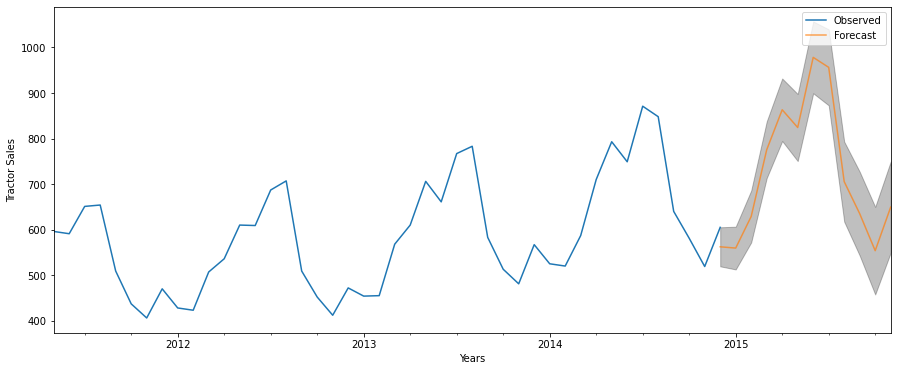

In [25]:
# plot the forecast along with the confidence band
axis = mkt_sales_data['Tractor-Sales'].plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

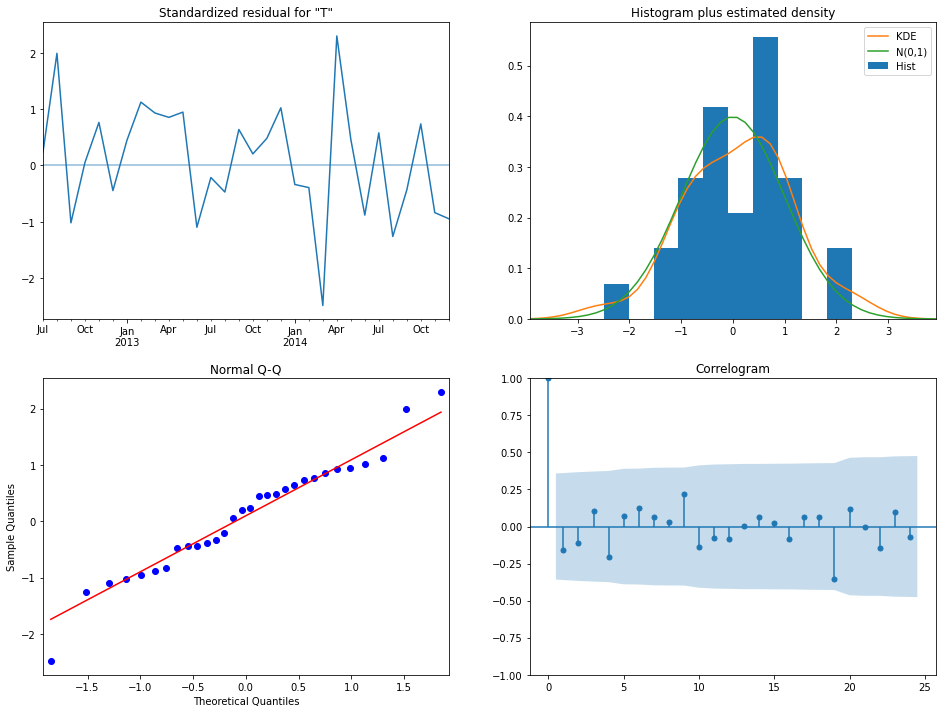

In [26]:
best_results.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()